### Problem Statement

Analyzing Zillow Housing Data to Predict and to accurately estimate property prices based on a set of features including location, property characteristics, and market trends, with the aim of assisting investors in making informed decisions in the real estate market.

#### Question.
1. What is the most significant house feature in determining the cost?
2. What are the top 3 zipcode?
3. Which categories of buyers should we prioritise to maximise on profits?
4. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data from the CSV file
file_path = 'zillow_data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to verify it's loaded correctly
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Data Procesing

In [2]:
# Convert the column names to datetime where applicable
data.columns = pd.to_datetime(data.columns, errors='ignore')

# Melt the dataframe to have dates in a single column and prices as values
melted_data = data.melt(id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'],
                        var_name='Date',
                        value_name='Price')

melted_data['Date'] = pd.to_datetime(melted_data['Date'])
melted_data = melted_data.sort_values(by=['RegionID', 'Date'])
melted_data_filled = melted_data.fillna(method='ffill').fillna(method='bfill')

# Convert 'Date' to datetime format
melted_data['Date'] = pd.to_datetime(melted_data['Date'])

# Sort the data by region and date for easier analysis
melted_data = melted_data.sort_values(by=['RegionID', 'Date'])

# Check for missing values
missing_values = melted_data.isnull().sum()

# Display the first few rows of the processed data and the missing values information
processed_head = melted_data.head()
(missing_values, processed_head)

(RegionID           0
 RegionName         0
 City               0
 State              0
 Metro         276395
 CountyName         0
 SizeRank           0
 Date               0
 Price         156891
 dtype: int64,
        RegionID  RegionName    City State        Metro CountyName  SizeRank  \
 5850      58196        1001  Agawam    MA  Springfield    Hampden      5851   
 20573     58196        1001  Agawam    MA  Springfield    Hampden      5851   
 35296     58196        1001  Agawam    MA  Springfield    Hampden      5851   
 50019     58196        1001  Agawam    MA  Springfield    Hampden      5851   
 64742     58196        1001  Agawam    MA  Springfield    Hampden      5851   
 
             Date     Price  
 5850  1996-04-01  113100.0  
 20573 1996-05-01  112800.0  
 35296 1996-06-01  112600.0  
 50019 1996-07-01  112300.0  
 64742 1996-08-01  112100.0  )

In [4]:
melted_data.shape
# Price values are median - to be confirmed.
# Metro - we can fill it using mode, given its a categorical data. We will investigate to see if its 
#answering any of our questions

(3901595, 9)

# Feature Engineering

In [5]:
# Ensure melted_data_filled is sorted by date
melted_data_filled = melted_data_filled.sort_values(by=['Date'])

# Lag Features: Create a 1-month lagged price feature
melted_data_filled['Price_lag1'] = melted_data_filled.groupby('RegionID')['Price'].shift(1)

# Rolling Window Statistics: Create a rolling mean and standard deviation feature for the last 3 months
melted_data_filled['Price_rolling_mean3'] = melted_data_filled.groupby('RegionID')['Price'].rolling(window=3).mean().reset_index(level=0, drop=True)
melted_data_filled['Price_rolling_std3'] = melted_data_filled.groupby('RegionID')['Price'].rolling(window=3).std().reset_index(level=0, drop=True)

# Month and Year Extraction: Extract month and year as separate features
melted_data_filled['Month'] = melted_data_filled['Date'].dt.month
melted_data_filled['Year'] = melted_data_filled['Date'].dt.year

# Display the first few rows of the dataframe to verify the new features
melted_data_filled.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,Date,Price,Price_lag1,Price_rolling_mean3,Price_rolling_std3,Month,Year
5850,58196,1001,Agawam,MA,Springfield,Hampden,5851,1996-04-01,113100.0,NaN,NaN,NaN,4,1996
9038,59257,3865,Plaistow,NH,Boston,Rockingham,9039,1996-04-01,124200.0,NaN,NaN,NaN,4,1996
4898,99058,97058,The Dalles,OR,The Dalles,Wasco,4899,1996-04-01,93500.0,NaN,NaN,NaN,4,1996
4259,69766,28203,Charlotte,NC,Charlotte,Mecklenburg,4260,1996-04-01,162500.0,NaN,NaN,NaN,4,1996
12290,88348,69145,Kimball,NE,North Platte,Kimball,12291,1996-04-01,133800.0,NaN,NaN,NaN,4,1996


# EDA and Visualization

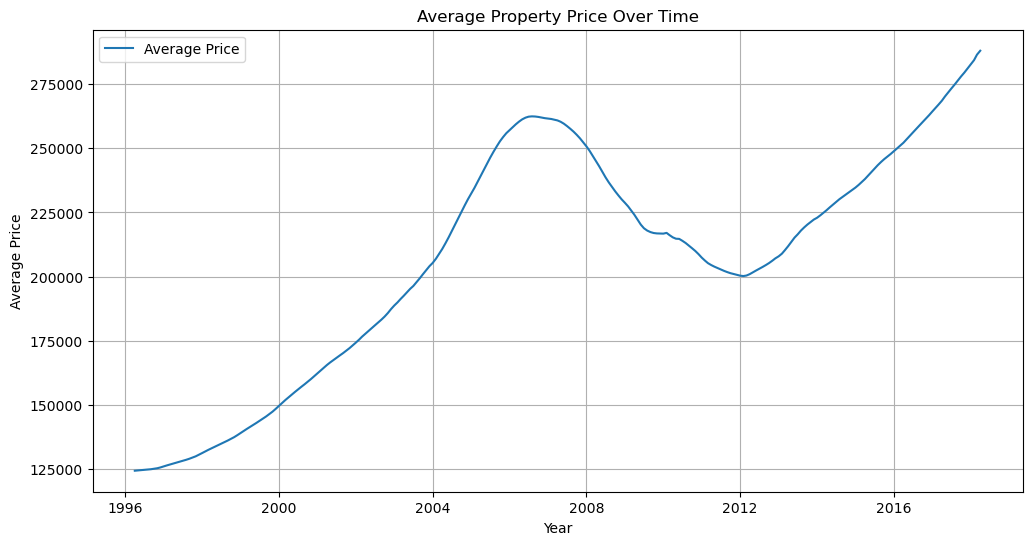

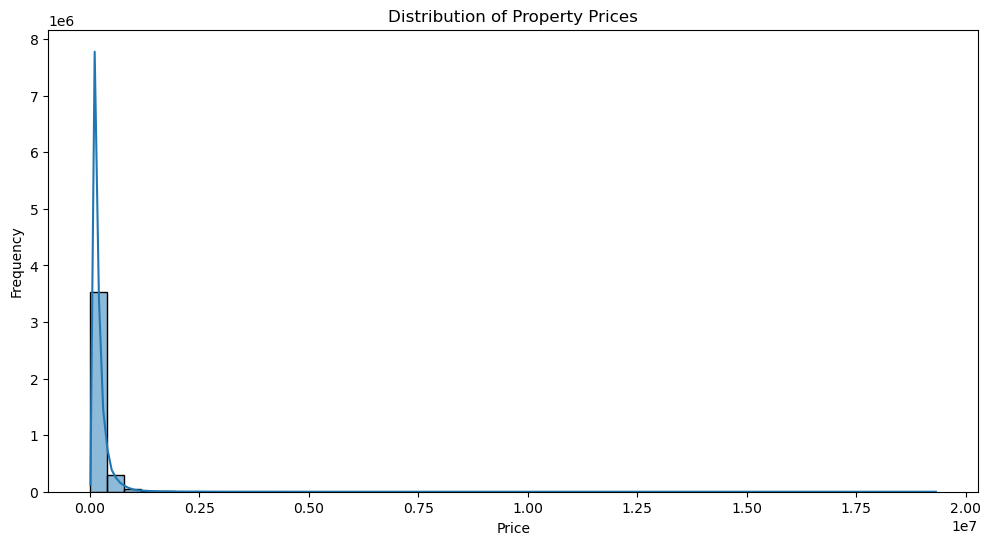

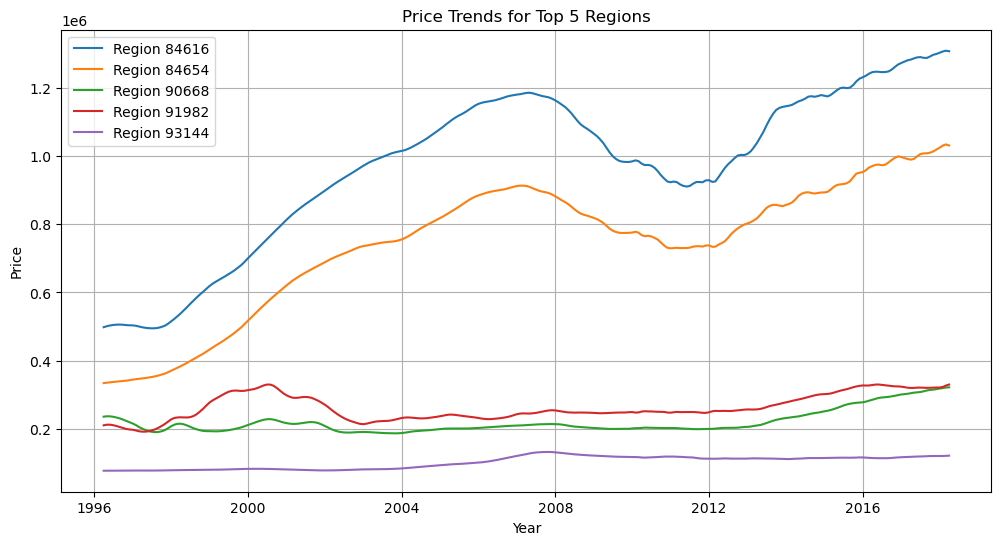

In [10]:
# 1. Trend Analysis
# Calculate average price per month
average_price_monthly = melted_data_filled.groupby('Date')['Price'].mean().reset_index()

# Plot the average price trend
plt.figure(figsize=(12, 6))
plt.plot(average_price_monthly['Date'], average_price_monthly['Price'], label='Average Price')
plt.title('Average Property Price Over Time')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.legend()
plt.grid(True)
plt.show()

# 2. Distribution Analysis
# Histogram of property prices
plt.figure(figsize=(12, 6))
sns.histplot(melted_data_filled['Price'], bins=50, kde=True)
plt.title('Distribution of Property Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# 3. Comparative Analysis
# Compare price trends of top 5 regions by size rank
top_regions = melted_data_filled[melted_data_filled['SizeRank'] <= 5]['RegionID'].unique()
top_regions_data = melted_data_filled[melted_data_filled['RegionID'].isin(top_regions)]

plt.figure(figsize=(12, 6))
for region in top_regions:
    region_data = top_regions_data[top_regions_data['RegionID'] == region]
    plt.plot(region_data['Date'], region_data['Price'], label=f'Region {region}')

plt.title('Price Trends for Top 5 Regions')
plt.xlabel('Year')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## Based on the above visualizations:

1.Average Property Price Over Time:
- The graph shows a long-term upward trend in average property prices from around 1996 until 2008.
- There is a significant dip observable around the 2008 mark, which aligns with the global financial crisis that impacted the housing market dramatically.
- There's a recovery and prices begin to increase again post-2012, suggesting a period of market correction and possible economic recovery or growth.
- The continued rise after 2012 may indicate a robust recovery and a return to a seller's market, with increasing property values.

2.Distribution of Property Prices:
- The histogram displays a highly right-skewed distribution of property prices, indicating that most properties are at the lower end of the price range, with a few properties at very high prices.
- The long tail to the right suggests the presence of some extremely high-value properties in the dataset. These could be luxury properties or properties in very high-demand areas.
- The distribution also suggests that the housing market is not evenly distributed but is dominated by properties that are more affordable to the general population.

3.Price Trends for Top 5 Regions:
- The multiple line graph compares price trends in the top 5 regions by size rank.
- It shows that different regions have different price trajectories, reflecting regional economic conditions, housing demand, and supply dynamics.
- One region (presumably Region 84616) shows a much steeper increase in property prices than the others, indicating a stronger market or possibly a more affluent area with higher property valuation.
- Other regions also show growth, but it is more modest compared to the steep rise and volatility of Region 84616.
- All regions show the impact of the 2008 financial crisis, with a noticeable dip in prices around that period. However, the recovery trajectories vary, suggesting different rates of economic recovery or differences in regional housing market resilience.


# Reshape from Wide to Long Format

In [11]:
id_vars = data.columns[:7]
date_columns = data.columns[7:]

# Reshape the dataset from wide to long format
long_format = pd.melt(data, id_vars=id_vars, value_vars=date_columns, var_name='Date', value_name='Price')

# Display the first few rows of the reshaped data
print(long_format.head())

   RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank     Date     Price  
0         1  1996-04  334200.0  
1         2  1996-04  235700.0  
2         3  1996-04  210400.0  
3         4  1996-04  498100.0  
4         5  1996-04   77300.0  


# ARIMA Modeling

In [16]:
# Aggregate the data by taking the mean across all regions for each month
# We ignore non-numeric columns in the aggregation
time_series_data = data.iloc[:, 7:].mean(axis=0)

# Convert the index to datetime format and sort the series
time_series_data.index = pd.to_datetime(time_series_data.index)
time_series_data = time_series_data.sort_index()

# Display the first few rows of the aggregated time series
time_series_data.head()

Series([], dtype: float64)

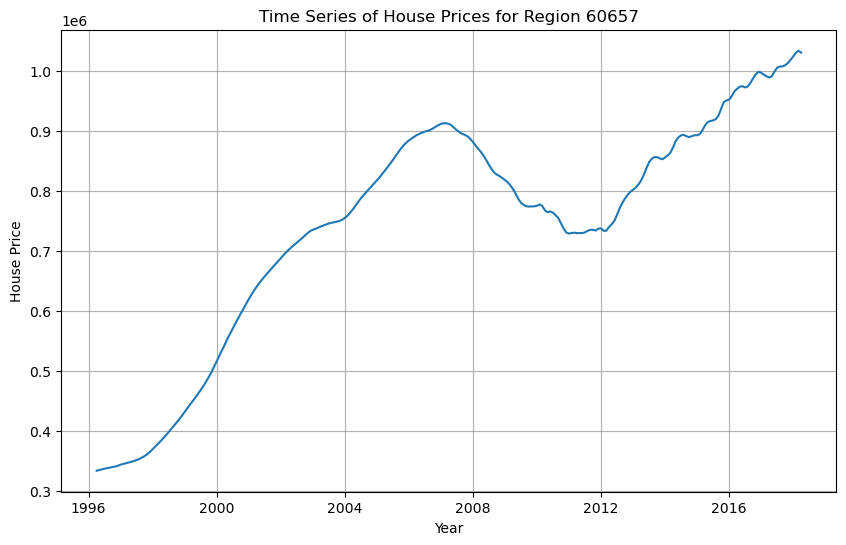

In [37]:
from statsmodels.tsa.stattools import adfuller

# Load the dataset
data = pd.read_csv('zillow_data.csv')

# Selecting the time series data for the first region
time_series = data.iloc[0, 7:].astype(float)

# Converting the index to datetime format
time_series.index = pd.to_datetime(data.columns[7:])

# Plotting the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series)
plt.title('Time Series of House Prices for Region 60657')
plt.xlabel('Year')
plt.ylabel('House Price')
plt.grid(True)
plt.show()

# Check the length of the time series and the presence of null values
time_series_length = len(time_series)

The Time Series of House Price displays the original house prices data for Region 60657.The plot shows an overall increasing trend over time, suggesting that house prices have generally gone up from 1996 to 2018.There is a notable dip around 2008, which corresponds to the global financial crisis and its impact on housing markets.

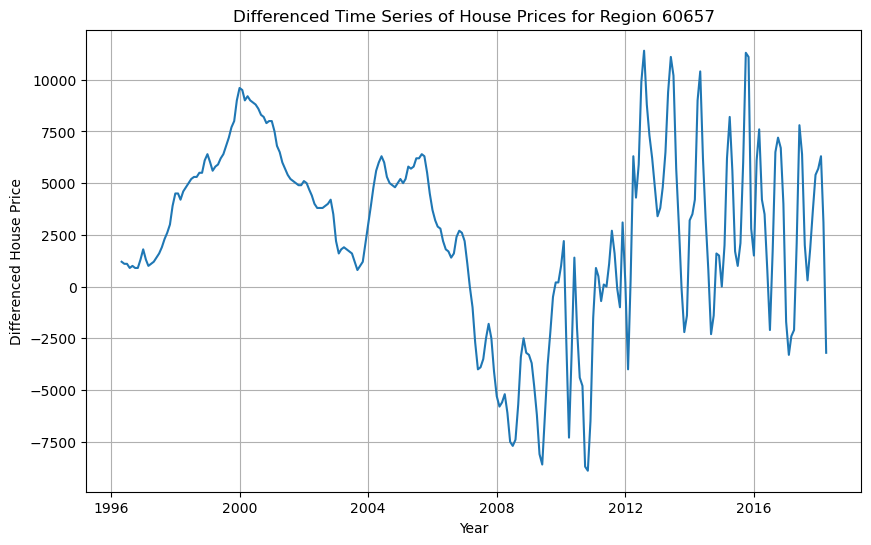

(-1.9429726695692509, 0.3121231116114112)

In [33]:
# Differencing the time series to make it stationary
time_series_diff = time_series.diff().dropna()

# Plotting the differenced time series
plt.figure(figsize=(10, 6))
plt.plot(time_series_diff)
plt.title('Differenced Time Series of House Prices for Region 60657')
plt.xlabel('Year')
plt.ylabel('Differenced House Price')
plt.grid(True)
plt.show()

# Performing the Augmented Dickey-Fuller test on the differenced series
adf_result_diff = adfuller(time_series_diff)

# Display the ADF statistics and p-value for the differenced series
adf_statistic_diff, p_value_diff = adf_result_diff[0], adf_result_diff[1]
adf_statistic_diff, p_value_diff

This chart shows the differenced house prices, which is a common technique used to remove trends and seasonal patterns to achieve stationarity in time series data.The plot appears to be more stable compared to the original time series, with no obvious trend or seasonality. However, the volatility seems to be increasing over time, especially after 2008.

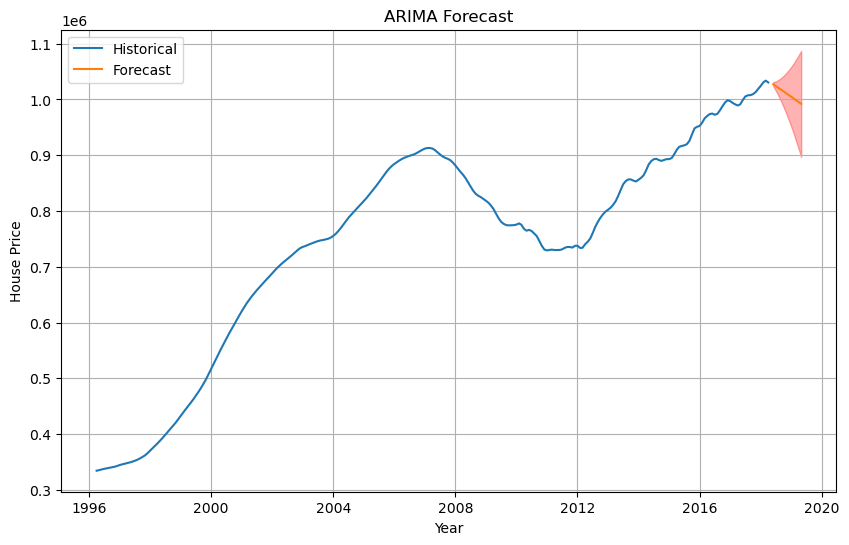

In [44]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

# Ensure the time series has a monthly frequency ('MS')
time_series.index = pd.date_range(start=time_series.index[0], periods=len(time_series), freq='MS')

# Fit the ARIMA model
p, d, q = auto_arima_model.order
model = ARIMA(time_series, order=(p, d, q))
fitted_model = model.fit()

# Make forecast
n_periods = 12  # for example, forecast 12 periods into the future
forecast_result = fitted_model.get_forecast(n_periods)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Historical')
future_dates = pd.date_range(time_series.index[-1], periods=n_periods + 1, freq='M')[1:]
plt.plot(future_dates, forecast, label='Forecast')
plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='red', alpha=0.3)
plt.title('ARIMA Forecast')
plt.xlabel('Year')
plt.ylabel('House Price')
plt.legend()
plt.grid(True)
plt.show()

- The chart presents both the historical data and the forecasted house prices using the ARIMA model.
- The historical data is the same as in the first chart, while the forecasted data shows predictions for future house prices, represented by the line beyond the historical data.
- The shaded area around the forecast represents the confidence interval (likely the 95% confidence interval), indicating the uncertainty associated with the predictions. The wider the shaded area, the higher the uncertainty.

# Recommendations

Based on the above results from the ARIMA modelling, some recommendations that could be made to stakeholders, such as real estate investors, analysts, and policymakers include: 

- Trend Awareness: The overall increasing trend in house prices indicates a growing market. Stakeholders should be aware that, historically, investments in this region have appreciated. However, they should also consider external factors that could influence future market conditions. 

- Market Volatility: The noticeable dip around 2008 and the increased volatility in prices should prompt stakeholders to consider the potential for future market disruptions. It's important to factor in economic indicators, market trends, and policy changes that could impact the real estate market. 

- Investment Strategy: If stakeholders are considering buying or selling properties, they should do so in the context of these forecasts. For buyers, this could mean anticipating price increases and purchasing sooner rather than later. For sellers, it might mean holding onto properties to benefit from potential future appreciation. 

- Risk Assessment: The confidence intervals in the forecast suggest there is uncertainty in the predictions. Stakeholders should account for this risk when making decisions, possibly by diversifying investments or creating contingency plans. 

- Consideration of External Factors: The ARIMA model is based solely on historical price data and does not account for external factors that can affect the housing market, such as interest rates, economic growth, demographic changes, and government policies. Stakeholders should use these forecasts as one part of a comprehensive analysis. 

- Continual Re-evaluation: The ARIMA model should be updated regularly with new data to refine future forecasts. As the real estate market is dynamic, regular re-evaluation will ensure that stakeholders are making informed decisions based on the most current information. 

- Policy Implications: For policymakers, the sustained increase in housing prices might prompt considerations of affordable housing policies or measures to stabilize the market. 

- Further Analysis: Additional analysis might be beneficial, such as considering different sub-markets within region 60657 or examining related economic variables that could provide a more holistic view of the market dynamics. 

 